In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import array
from scipy.interpolate import RegularGridInterpolator
import sys
import math
from skmisc.loess import loess

In [2]:
def main(day):
    # print('in')
    fn      = '/glade/work/geethma/research/data_cygnss/2019/cyg.ddmi.s201902'+f'{day:02d}'+'-003000-e201902'+f'{day:02d}'+'-233000.l3.grid-wind.a30.d31.nc'
    # cyg.ddmi.s20190226-003000-e20190226-233000.l3.grid-wind.a30.d31
    dsi     = nc.Dataset(fn)
    # ds.append(dsi)
    lons	= dsi.variables['lon'][:]           #size=1800 #Range is 0.1 .. 359.9 #resolution=0.2
    lats	= dsi.variables['lat'][:]        #size=400 #Range is -39.9 .. 39.9 #resolution=0.2
    u		= dsi.variables['wind_speed'][:,:,:]    #float wind_speed(time, lat, lon) #units = "m s-1"
    globals()['time']    = dsi.variables['time'][:]          #size=24
    dsi.close
##############
    fna     = '/glade/work/geethma/research/data_amsr2/2019/RSS_AMSR2_ocean_L3_daily_2019-02-'+f'{day:02d}'+'_v08.2.nc'
    # RSS_AMSR2_ocean_L3_daily_2019-02-09_v08.2
    dsa     = nc.Dataset(fna)
    lonsa   = dsa.variables['lon'][:]          #size=1440  #Range is 0.125 .. 359.875 #resolution=0.25
    latsa	= dsa.variables['lat'][:]          #size=720 #Range is -89.875 .. 89.875 #resolution=0.25
    ua      = dsa.variables['wind_speed_LF'][:,:,:]  #float32 wind_speed_LF(pass, lat, lon)
    timea   = dsa.variables['time'][:,:,:]            #(pass, lat, lon) shape=(2,720,1440)
    passa   = dsa.variables['pass'][:]
    raina   = dsa.variables['rain_rate'][:,:,:]
    dsa.close
# ############
# ##############
    # x = lons
    x = np.array(lons)
    y = np.array(lats)
    z = np.array(time)
    # zg, yg, xg = np.meshgrid(z,y, x, indexing='ij', sparse=True)
    # data = u
    globals()['my_interpolate'] = RegularGridInterpolator((z,y,x), u, method='nearest')  #a function [0:23,-39.9:39.9,0.1:359]
    xa = np.array(lonsa)
    ya = np.array(latsa)
    za = np.array(passa)
    # zga, yga, xga = np.meshgrid(za, ya, xa, indexing='ij', sparse=True)
    # dataa = np.array(ua)
    globals()['my_interpolate_a'] = RegularGridInterpolator((za,ya,xa), ua, method='nearest')#a function [1:2,-89.9:89.9,0.1:359]
    globals()['my_interpolate_t'] = RegularGridInterpolator((za,ya,xa), timea, method='nearest')
    globals()['my_interpolate_r'] = RegularGridInterpolator((za,ya,xa), raina, method='nearest') #rain_rate
    

    ##########
    
    

In [3]:
def save(day):
    np.savez_compressed('/glade/work/geethma/research/npzfilesn/2019_/january/new_02'+f'{day:02d}'+'2019', cw=cyg, aw=am, b=bias, ar=r, cT=cT, aT=aT, lon=longt, lat=latit) #u10_monthdateyear.npz


In [4]:
k = 18
for day in range(k,k+2):
    main(day)

    am = []
    cyg = []
    r = []
    bias = []
    cT = []
    aT = []
    longt = []
    latit = []
    for i in range(0,24): #time_cyg (0,24)
        for j in range(1,3): #pass (1,3)
            for k in np.arange(-39,40,0.5): #lats(-39,40)
                for l in np.arange(1,360,0.5): #lons(1,360)
                    pt  = [i,k,l]
                    pta = [j,k,l]
                    cygn = my_interpolate(pt)
                    amsr = my_interpolate_a(pta)
                    amT = my_interpolate_a(pta)
                    rr = my_interpolate_r(pta)
                    #print(cygn)
                    if cygn>1 and amsr>1 and cygn<50 and amsr<50:
                        t = abs(time[i] - amT)
                        if t<=0.5:
                          b = (cygn[0]-amsr[0])
                          bias.append(b)
                          r.append(rr[0])
                          cyg.append(cygn[0])
                          am.append(amsr[0])
                          cT.append(time[i])
                          aT.append(amT[0])
                          longt.append(l)
                          latit.append(k)

    save(day)


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import glob
#####data in npz npzfiles
#####cw=cyg, aw=am, b=bias, ar=r, cT=cT, aT=aT, lon=longt, lat=latit
# fig = plt.figure(figsize=(12,6))
fn = glob.glob('/glade/work/geethma/research/npzfilesn/2019_/january/new*npz')  #u10*npz
fn = np.array(fn)
awf=[]
cwf = []
bf = []
# print(fn)
for i in range(0,len(fn)): #len(fn)
    # print (i)
    d = np.load(fn[i])
    aw = np.array(d['aw'])
    cw = np.array(d['cw'])
    ##################
    if aw[i]<20 and cw[i]<20:
        for i in range(0,len(aw)):
            awf.append(aw[i])
            cwf.append(cw[i])
            bf.append(cw[i]-aw[i])
        
# plt.plot(awf, cwf, "o", label='scatter plot')

bm = np.round(np.mean(bf),2) #mean bias

# x = [0,max(cwf)]
# y = [0,max(cwf)]
# plt.plot(x,y,c='r',linestyle='--',label='1-to-1 plot')
# plt.legend()
# plt.text(11, 2, 'bias = '+str(bm)+'(m/s)')

z = np.polyfit(awf,cwf, 1)
poly = np.poly1d(z)
zz = poly(awf)
# plt.plot(awf, zz,label='linear fit')

# plt.title('AMSR vs CYGNSS Wind Speeds on Jan 2019')
# plt.ylabel('CYGNSS (m/s)')
# plt.xlabel('AMSR (m/s)')
# plt.show()
# plt.savefig('/glade/work/geethma/research/npzfilesn/2019/january2/plots/plot_amVScyg.png') #/plots
#"/glade/work/geethma/research/npzfilesn/2019/jann/u10_01072019.npz"


#### bin data cygnss vs amsr

In [4]:

from scipy import stats
bin_means, bin_edges, binnumber = stats.binned_statistic(awf, cwf, 'mean', bins=100)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

#### loess cygnss vs amsr

In [5]:
x = np.array(bin_centers[:])
y = np.array(bin_means[:])
ind = np.argsort(x)
xx = np.sort(x)
yy = y[ind]

l = loess(xx,yy)
l.fit()
pred = l.predict(xx, stderror=True)
conf = pred.confidence()

lowess = pred.values
ll = conf.lower
ul = conf.upper

#### bias bin and loess

In [6]:
bin_meansb, bin_edgesb, binnumberb = stats.binned_statistic(awf, bf, 'mean', bins=100)
bin_widthb = (bin_edgesb[1] - bin_edgesb[0])
bin_centersb = bin_edgesb[1:] - bin_widthb/2

xb = np.array(bin_centersb[:])
yb = np.array(bin_meansb[:])
indb = np.argsort(xb)
xb = np.sort(xb)
yb = yb[ind]

l = loess(xb,yb)
l.fit()
pred = l.predict(xb, stderror=True)
conf = pred.confidence()

lowessb = pred.values
llb = conf.lower
ulb = conf.upper

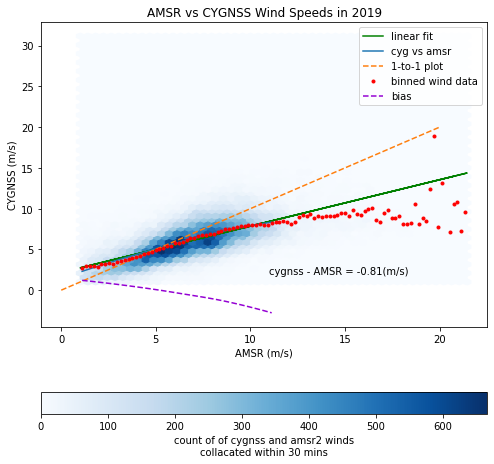

In [16]:
import numpy as np
import matplotlib.pyplot as plt

fig= plt.figure(figsize=(8, 8))

hb = plt.hexbin(awf, cwf, gridsize=50, cmap='Blues')
plt.title('AMSR vs CYGNSS Wind Speeds on Jan 2019')
plt.ylabel('CYGNSS (m/s)')
plt.xlabel('AMSR (m/s)')
cb = fig.colorbar(hb, orientation='horizontal')
cb.set_label('count of of cygnss and amsr2 winds\ncollacated within 30 mins')

plt.plot(awf, zz, label='linear fit',color='g')
plt.plot(xx, lowess, label='cyg vs amsr')
plt.plot([0,20],[0,20],linestyle='--',label='1-to-1 plot')
plt.plot(bin_centers[:], bin_means[:], 'r.', label='binned wind data')
plt.fill_between(xx,ll,ul,alpha=.33)
plt.plot(xb, lowessb, color = 'darkviolet', linestyle = '--',label='bias')
plt.fill_between(xb,llb,ulb,alpha=.33)

plt.title('AMSR vs CYGNSS Wind Speeds in 2019')
plt.ylabel('CYGNSS (m/s)')
plt.xlabel('AMSR (m/s)')
plt.legend(fontsize=10)
plt.text(11, 2, 'cygnss - AMSR = '+str(bm)+'(m/s)')

plt.show()


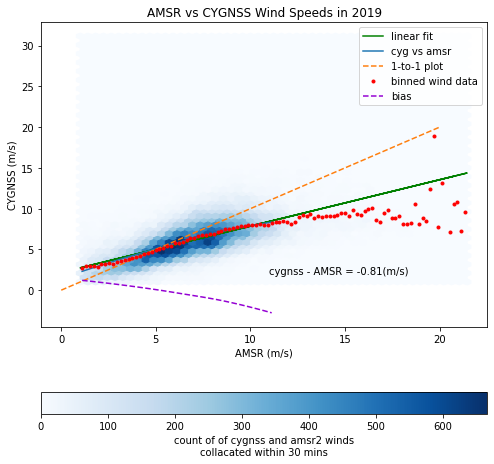

In [7]:
import numpy as np
import matplotlib.pyplot as plt

fig= plt.figure(figsize=(8, 8))

hb = plt.hexbin(awf, cwf, gridsize=50, cmap='Blues')
plt.title('AMSR vs CYGNSS Wind Speeds on Jan 2019')
plt.ylabel('CYGNSS (m/s)')
plt.xlabel('AMSR (m/s)')
cb = fig.colorbar(hb, orientation='horizontal')
cb.set_label('count of of cygnss and amsr2 winds\ncollacated within 30 mins')

plt.plot(awf, zz, label='linear fit',color='g')
plt.plot(xx, lowess, label='cyg vs amsr')
plt.plot([0,20],[0,20],linestyle='--',label='1-to-1 plot')
plt.plot(bin_centers[:], bin_means[:], 'r.', label='binned wind data')
plt.fill_between(xx,ll,ul,alpha=.33)
plt.plot(xb, lowessb, color = 'darkviolet', linestyle = '--',label='bias')
plt.fill_between(xb,llb,ulb,alpha=.33)

plt.title('AMSR vs CYGNSS Wind Speeds in 2019')
plt.ylabel('CYGNSS (m/s)')
plt.xlabel('AMSR (m/s)')
plt.legend(fontsize=10)
plt.text(11, 2, 'cygnss - AMSR = '+str(bm)+'(m/s)')

plt.show()


Text(11, 2, 'cygnss - AMSR = -0.81(m/s)')

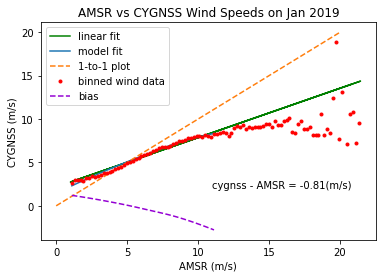

In [46]:
plt.plot(awf, zz, label='linear fit',color='g')
plt.plot(xx, lowess, label='model fit')
plt.plot([0,20],[0,20],linestyle='--',label='1-to-1 plot')
plt.plot(bin_centers[:], bin_means[:], 'r.', label='binned wind data')
# plt.scatter(awf,bf,color='darkviolet',label='bias')
plt.plot(xb, lowessb, color = 'darkviolet', linestyle = '--',label='bias')
plt.fill_between(xx,ll,ul,alpha=.33)
plt.title('AMSR vs CYGNSS Wind Speeds on Jan 2019')
plt.ylabel('CYGNSS (m/s)')
plt.xlabel('AMSR (m/s)')
plt.legend(fontsize=10)
plt.text(11, 2, 'cygnss - AMSR = '+str(bm)+'(m/s)')

Text(0.5, 0, 'AMSR (m/s)')

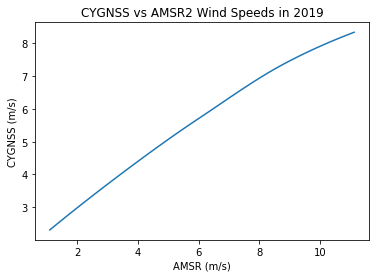

In [23]:
plt.plot(xx, lowess)
plt.fill_between(xx,ll,ul,alpha=.33)
plt.title('CYGNSS vs AMSR2 Wind Speeds in 2019')
plt.ylabel('CYGNSS (m/s)')
plt.xlabel('AMSR (m/s)')

Text(0.5, 0, 'AMSR (m/s)')

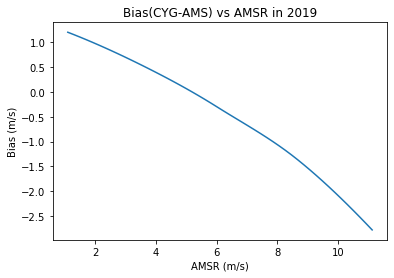

In [7]:
plt.plot(xb, lowessb, label='MODEL FIT')
plt.fill_between(xb,llb,ulb,alpha=.33)
plt.title('Bias(CYG-AMS) vs AMSR in 2019')
plt.ylabel('Bias (m/s)')
plt.xlabel('AMSR (m/s)')

Text(0.5, 0, 'AMSR (m/s)')

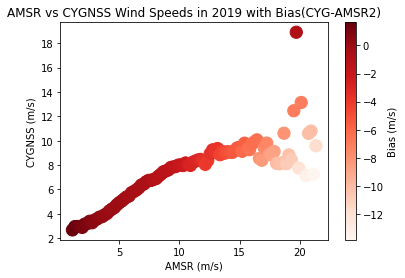

In [22]:
scatter = plt.scatter(bin_centers[:], bin_means[:], s=150, c=bin_meansb[:], cmap='Reds',vmin=min(bin_meansb[:]), vmax=max(bin_meansb[:]))
cbar1 = plt.colorbar(scatter)
cbar1.ax.set_ylabel('Bias (m/s)')
plt.title('AMSR vs CYGNSS Wind Speeds in 2019 with Bias(CYG-AMSR2)')
plt.ylabel('CYGNSS (m/s)')
plt.xlabel('AMSR (m/s)')


In [24]:
from sklearn import preprocessing
awfn = preprocessing.normalize([awf])
cwfn = preprocessing.normalize([cwf])

In [25]:
from scipy import stats
x_pdf=stats.maxwell.pdf(awfn)
y_pdf=stats.maxwell.pdf(cwfn)

Text(0.5, 0, 'bias (m/s)')

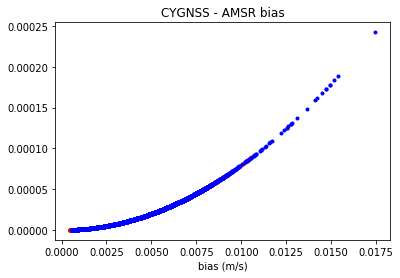

In [27]:
fig = plt.figure()
plt.plot(awfn, x_pdf, 'r.', label='bias pdf')
plt.plot(cwfn, y_pdf, 'b.', label='bias pdf')
plt.title('CYGNSS - AMSR bias')
plt.xlabel('bias (m/s)')
# plt.ylabel('AMSR (m/s)')